# RetinaMNIST with rotations

In this exercise your goal will be to solve an object detection training and prediction task using the anchor-based approach.
**As a part of your solution you should provide a report summarizing your findings and results of the conducted experiments.**

##TLDR; overview

In this task one should:
- determine the size of the feasible anchors for the object detection task posed in this Assignment,
- build an object detection model using the variant of `RetinaNet`,
- prepare a matching suite which will match predicted anchors with ground truth bounding boxes,
- train an object detection model using a variant of `RetinaLoss`.

Hints and comments:

- Model architecture and loss are heavily inspired by [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf) paper,
- you can freely subclass and extend the interface of classes in this exercise,
- be sure that you understand the concept of an anchor for object detection, covered during the lecture about Object Detection. There are many great tutorials and articles about it (e.g. [this](https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9) one, note however that we are not implementing ignoring boxes for simplicity).

### Data description

In this task we will paste bounding boxes with digits **from 1 to 5** randomly selected from `MNIST` dataset on a canvas of size `(128, 128)` and **randomly flipped by 90 degrees**. We assume that:

- the two boxes from a canvas should have no more than `0.1` of `iou` overlap,
- the digits are fully contained in canvas,
- boxes are modeled using `MnistBox` class,
- canvas is modeled using `MnistCanvas` class.

Let us have a look at definition of these classes:

In [1]:
from typing import List
from typing import Optional
from typing import Tuple

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MnistBox:

    def __init__(
        self,
        x_min: int,
        y_min: int,
        x_max: int,
        y_max: int,
        class_nb: Optional[int] = None,
        rotated: Optional[bool] = None,
    ):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.class_nb = class_nb
        self.rotated = rotated
    
    @property
    def x_diff(self):
        return self.x_max - self.x_min
    
    @property
    def y_diff(self):
        return self.y_max - self.y_min

    def __repr__(self):
        return f'Mnist Box: x_min = {self.x_min},' +\
               f' x_max = {self.x_max}, y_min = {self.y_min},' +\
               f' y_max = {self.y_max}. Class = {self.class_nb}.' +\
               f' Rotated = {self.rotated}.'

    def plot_on_ax(self, ax, color: Optional[str] = 'r'):
        ax.add_patch(
            patches.Rectangle(
                (self.y_min, self.x_min),
                 self.y_diff,
                 self.x_diff,
                 linewidth=1,
                 edgecolor=color,
                 facecolor='none',
            )
        )
        if not self.class_nb is None:
            ax.text(
                self.y_min,
                self.x_min,
                f'{self.class_nb}' if not self.rotated else f'{self.class_nb}*',
                bbox={"facecolor": color, "alpha": 0.4},
                clip_box=ax.clipbox,
                clip_on=True,
        )

    @property
    def area(self):
        return max((self.x_max - self.x_min), 0) * max((self.y_max - self.y_min), 0)

    def iou_with(self, other_box: "MnistBox"):
        aux_box = MnistBox(
            x_min=max(self.x_min, other_box.x_min),
            x_max=min(self.x_max, other_box.x_max),
            y_min=max(self.y_min, other_box.y_min),
            y_max=min(self.y_max, other_box.y_max),
        ) 
        return aux_box.area / (self.area + other_box.area - aux_box.area)


class MnistCanvas:

    def __init__(
        self,
        image: np.ndarray,
        boxes: List[MnistBox],
    ):
        self.image = image
        self.boxes = boxes

    def add_digit(
        self,
        digit: np.ndarray,
        class_nb: int,
        x_min: int,
        y_min: int,
        rotated=None,
        iou_threshold=0.1,
    ) -> bool:
        """
        Add a digit to an image if it does not overlap with existing boxes
        above iou_threshold.
        """
        image_x, image_y = digit.shape
        if x_min >= self.image.shape[0] and y_min >= self.image.shape[1]: # or?
            raise ValueError('Wrong initial corner box')
        new_box_x_min = x_min
        new_box_y_min = y_min
        new_box_x_max = min(x_min + image_x, self.image.shape[0])
        new_box_y_max = min(y_min + image_y, self.image.shape[1])
        new_box = MnistBox(
            x_min=new_box_x_min,
            x_max=new_box_x_max,
            y_min=new_box_y_min,
            y_max=new_box_y_max,
            class_nb=class_nb,
            rotated=rotated,
        )
        old_background = self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ]
        for box in self.boxes:
            if new_box.iou_with(box) > iou_threshold:
                return False
        self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ] = np.maximum(old_background, digit)
        self.boxes.append(
            new_box
        ) 
        return True
        
    def get_torch_tensor(self) -> torch.Tensor:
        np_image = self.image.astype('float32')
        np_image = np_image.reshape(
            (1, 1, self.image.shape[0], self.image.shape[1])
        )
        return torch.from_numpy(np_image).to(DEVICE)

    @classmethod
    def get_empty_of_size(cls, size: Tuple[int, int]):
        return cls(
            image=np.zeros(size),
            boxes=[],
        )

    def plot(self, boxes: Optional[List[MnistBox]] = None, title=None):
        fig, ax = plt.subplots()
        ax.imshow(self.image)
        boxes = boxes or self.boxes# przypisuje self.boxes, jezeli boxes == None
        for box in boxes:
            box.plot_on_ax(ax)
        if title is not None:
            ax.set_title(title)
        plt.show()

Each canvas has 3-6 boxes with randomly selected digits. The digits for training data are from first 10K examples from `MNIST` train data. The digits for test data are selected from first 1K examples from `MNIST` test data. The Dataset is generated using the following functions:

In [2]:
from keras.datasets import mnist
import numpy as np


mnist_data = mnist.load_data()
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist_data


def crop_insignificant_values(digit:np.ndarray, threshold=0.1):
    bool_digit = digit > threshold
    x_range = bool_digit.max(axis=0)
    y_range = bool_digit.max(axis=1)
    start_x = (x_range.cumsum() == 0).sum()
    end_x = (x_range[::-1].cumsum() == 0).sum()
    start_y = (y_range.cumsum() == 0).sum()
    end_y = (y_range[::-1].cumsum() == 0).sum()
    return digit[start_y:-end_y - 1, start_x:-end_x - 1]


TRAIN_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_train[:10000])
]
TRAIN_CLASSES = mnist_y_train[:10000]

TEST_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_test[:1000])
]
TEST_CLASSES = mnist_y_test[:1000]


def get_random_canvas(
    digits: Optional[List[np.ndarray]] = None,
    classes: Optional[List[int]] = None,
    nb_of_digits: Optional[int] = None,
    ):
    digits = digits if digits is not None else TRAIN_DIGITS
    classes = classes if classes is not None else TRAIN_CLASSES
    nb_of_digits = nb_of_digits if nb_of_digits is not None else np.random.randint(low=3, high=6 + 1)
    new_canvas = MnistCanvas.get_empty_of_size(size=(128, 128))
    attempts_done = 0
    while attempts_done < nb_of_digits:
        current_digit_index = np.random.randint(len(digits))
        current_digit_class = classes[current_digit_index]
        if current_digit_class not in [1, 2, 3, 4, 5]:
            continue
        current_digit = digits[current_digit_index]
        rotate = np.random.random() > 0.5
        if rotate:
            current_digit = np.rot90(current_digit)
        random_x_min = np.random.randint(0, 128 - current_digit.shape[0] - 3)
        random_y_min = np.random.randint(0, 128 - current_digit.shape[1] - 3)
        if new_canvas.add_digit(
            digit=current_digit,
            x_min=random_x_min, # tam gdzie ma znajdować się nowa liczba, x_min
            y_min=random_y_min, # tam gdzie ma znajdować się nowa liczba, y_min
            class_nb=current_digit_class,
            rotated=rotate,
        ):
            attempts_done += 1
    return new_canvas

Let us have a look at example canvas (rotated digits have additional *added to description).

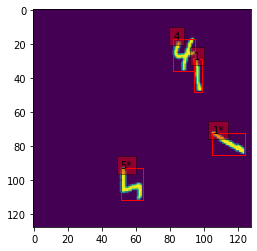

In [3]:
mnist_canvas = get_random_canvas()
mnist_canvas.plot()

Now - let us generate test canvas:

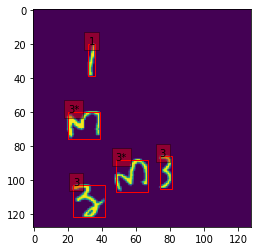

In [4]:
TEST_CANVAS_SIZE = 256
TEST_SEED = 42 # DO NOT CHANGE THIS LINE.

np.random.seed(TEST_SEED)

TEST_CANVAS = [
    get_random_canvas(
        digits=TEST_DIGITS,
        classes=TEST_CLASSES,
    )
    for _ in range(TEST_CANVAS_SIZE)
]

TEST_CANVAS[0].plot()

For training one can either:
- generate `TRAIN_CANVAS` similarly to `TEST_CANVAS` creation,
- use the fact that `get_random_canvas()` generates a random train canvas and generate training data on-the-fly.

### Anchor size analysis (2pts)

For this task:
1. Sample at least 1000 random canvas.
2. Analyze the sizes (heights and widths) of the `MnistBox`es from this canvas.
3. Select the anchor sizes which will match the problem the best.

Selected anchor sizes should be stored in a sensible manner in `ANCHOR_SIZES` list.

In [5]:
def calc_anchors(anchor_sizes):
        anchors = []
        for i in range(16):
            for j in range(16):
                center_x = (i + 0.5) * 8
                center_y = (j + 0.5) * 8
                for anchor_size in anchor_sizes:
                    w, h = anchor_size
                    x_min = center_x - w / 2
                    x_max = center_x + w / 2
                    y_min = center_y - h / 2
                    y_max = center_y + h / 2
                    anchor = MnistBox(x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
                    anchors.append(anchor)
        return anchors

In [ ]:
!pip install seaborn

<AxesSubplot:>

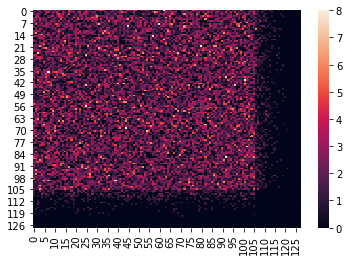

In [6]:
import seaborn as sbn

xy_diff = []
min_dist = np.zeros((128,128))
for _ in range(5000):
    canvas = get_random_canvas()
    for box in canvas.boxes:
        min_dist[box.x_min][box.y_min] += 1
        xy_diff.append([box.x_diff, box.y_diff])

sbn.heatmap(min_dist)

<AxesSubplot:>

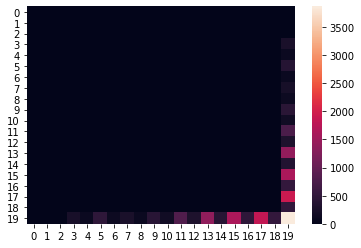

In [7]:
max_diff = max(xy_diff)

diff_counter = np.zeros((max_diff[0] + 1, max_diff[1] + 1))
for diff in xy_diff:
    diff_counter[diff[0]][diff[1]] += 1

sbn.heatmap(diff_counter)

In [8]:
import collections
import matplotlib.pyplot as plt


ANCHOR_SIZES = np.unique(xy_diff, axis=0)
print("ANCHOR_SIZES:", ANCHOR_SIZES)

ANCHOR_SIZES: [[ 2 19]
 [ 3 19]
 [ 4 19]
 [ 5 19]
 [ 6 19]
 [ 7 19]
 [ 8 19]
 [ 9 19]
 [10 19]
 [11 19]
 [12 19]
 [13 19]
 [14 19]
 [15 19]
 [16 19]
 [17 19]
 [18 19]
 [19  2]
 [19  3]
 [19  4]
 [19  5]
 [19  6]
 [19  7]
 [19  8]
 [19  9]
 [19 10]
 [19 11]
 [19 12]
 [19 13]
 [19 14]
 [19 15]
 [19 16]
 [19 17]
 [19 18]
 [19 19]]


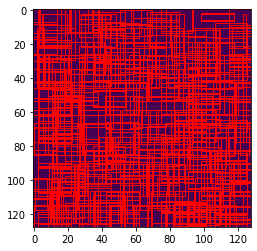

In [9]:
anchors = calc_anchors(ANCHOR_SIZES)
new_canvas = MnistCanvas(np.zeros((128, 128)), np.random.choice(anchors, 500))
new_canvas.plot()

In [10]:
ANCHOR_SIZES2 = [[x, y] for x, y in ANCHOR_SIZES if (x + y) % 2 == 0]
ANCHOR_SIZES2

[[3, 19],
 [5, 19],
 [7, 19],
 [9, 19],
 [11, 19],
 [13, 19],
 [15, 19],
 [17, 19],
 [19, 3],
 [19, 5],
 [19, 7],
 [19, 9],
 [19, 11],
 [19, 13],
 [19, 15],
 [19, 17],
 [19, 19]]

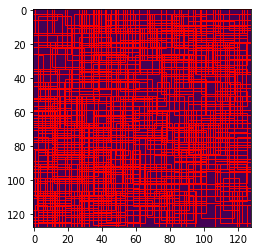

In [11]:
anchors = calc_anchors(ANCHOR_SIZES2)
new_canvas = MnistCanvas(np.zeros((128, 128)), np.random.choice(anchors, 500))
new_canvas.plot()

In [12]:
ANCHOR_SIZES3 = [[x, y] for x, y in ANCHOR_SIZES if (x + y) % 3 == 1]
ANCHOR_SIZES3

[[3, 19],
 [6, 19],
 [9, 19],
 [12, 19],
 [15, 19],
 [18, 19],
 [19, 3],
 [19, 6],
 [19, 9],
 [19, 12],
 [19, 15],
 [19, 18]]

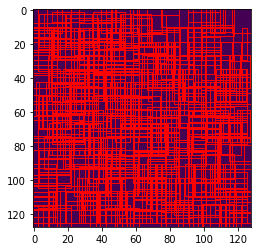

In [13]:
anchors = calc_anchors(ANCHOR_SIZES3)
new_canvas = MnistCanvas(np.zeros((128, 128)), np.random.choice(anchors, 500))
new_canvas.plot()

In [14]:
ANCHOR_SIZES4 = [[x, y] for x, y in ANCHOR_SIZES if (x + y) % 4 == 2]
ANCHOR_SIZES4

[[3, 19],
 [7, 19],
 [11, 19],
 [15, 19],
 [19, 3],
 [19, 7],
 [19, 11],
 [19, 15],
 [19, 19]]

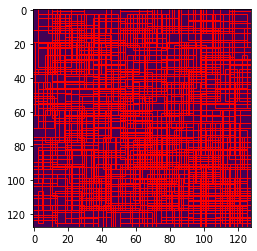

In [15]:
anchors = calc_anchors(ANCHOR_SIZES4)
new_canvas = MnistCanvas(np.zeros((128, 128)), np.random.choice(anchors, 500))
new_canvas.plot()

### Model building (2pt)


One should build a model for digit detection in $\texttt{pytorch}$. Model should consist of:

#### $\texttt{backbone}$:

We provided you with a backbone model architecture that accepts a `MnistCanvas` instance and output a tensor with shape $(1, 16, 16, 128)$. It should be trained together with the rest of your solution.

#### $\texttt{anchors}$:

List of `MnistBox`es where each box:

- should have size of one of selected `ANCHOR_SIZES`,
- should have center coordinates on canvas of type $\left(\left(m + \frac{1}{2}\right) * 8, \left(n + \frac{1}{2}\right) * 8\right)$  for $m, n \in \{0, 1, \dots, 16 - 1\}$,

`MnistBox` with anchor should have an attribute `class_nb` set to `None`.

#### $\texttt{digitClassificationHead}$:

$\texttt{digitClassificationHead}$ should accept backbone output as an input and output `digit_classification_output` tensor of shape $(len(\texttt{anchors)}, 5)$, where the value $ch_{i, j}$, which is the value of i-th row and j-th column, has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit of class $j + 1$ (ground truth box).

#### $\texttt{rotationClassificationHead}$:

$\texttt{rotationClassificationHead}$ should accept backbone output as an input and output `rotation_classification_output` tensor of shape $(len(\texttt{anchors)}, 2)$, where the value $ch_{i, j}$, which is the value of i-th row and j-th column, has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit which was not rotated when $j = 0$ and was rotated when $j = 1$.

#### $\texttt{boxRegressionHead}$:

$\texttt{boxRegressionHead}$ should accept backbone output as an input and output `box_regression_output` tensor of shape $(len(\texttt{anchors)}, 4)$, where the value $br_{i}$, which is the value of i-th row, has a property that if there is a ground truth digit box $\texttt{GTBox}$ - significantly overlapping with $\texttt{anchor}[i]$ then the following properties hold:

$$\texttt{GTBox.x_min} = \texttt{anchor[i].x_min} + br_{i, 0},$$ 
$$\texttt{GTBox.x_max} = \texttt{anchor[i].x_max} + br_{i, 1},$$ 
$$\texttt{GTBox.y_min} = \texttt{anchor[i].y_min} + br_{i, 2},$$ 
$$\texttt{GTBox.y_max} = \texttt{anchor[i].y_max} + br_{i, 3}.$$ 

#### *Hint*: be careful with a construction of a head output as a simple reshaping might cause unexpected permutation of anchors.

### Model output

Model should output `DigitDetectionModelOutput` class defined below.

#### Comment on _significant overlap_:

The meaning of significant overlap will be described later.

In [16]:
from torch import nn


class DigitDetectionModelOutput:

    def __init__(
        self,
        anchors: List[MnistBox],
        digit_classification_output: torch.Tensor,
        rotation_classification_output: torch.Tensor,
        box_regression_output: torch.Tensor,
    ):
        self.anchors = anchors
        self.digit_classification_output = digit_classification_output
        self.box_regression_output = box_regression_output
        self.rotation_classification_output = rotation_classification_output


class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.output_shape = (16, 16, 128)
        self.first_block = torch.nn.Sequential(
            nn.Conv2d(1, 16, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.blocks = torch.nn.ModuleList(
            [torch.nn.Sequential(*[
                nn.Conv2d(16 * (2 ** i), 16 * (2 ** (i + 1)), (3, 3), padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
              ]) for i in range(1, 3)
            ]
        )

    def forward(self, x: MnistCanvas) -> torch.Tensor:
        image = torch.Tensor(x.image).to(DEVICE).view(1, 1, 128, 128)
        aux = self.first_block(image)
        for block in self.blocks:
            aux = block(aux)
        return aux

    
class Head(nn.Module):
    def __init__(self, num_anchors, num_classes=5, is_regression_head=False):
        super().__init__()
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        self.is_regression_head = is_regression_head
        self.output_shape = (num_anchors, num_classes)
        self.classification_block = nn.Sequential(
            nn.Conv2d(128, 256, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(256, (num_anchors // 256) * num_classes, (3, 3), padding=1))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.classification_block(x)
        x = x.permute(0, 2, 3, 1)
        x = x.reshape(self.num_anchors, self.num_classes)
        return x


class DigitDetectionModel(nn.Module):
    def __init__(self, anchor_sizes):
        super().__init__()
        self.anchors = self.calc_anchors(anchor_sizes)
        self.backbone = Backbone().to(DEVICE)
        self.digit_classification_head = Head(num_anchors=len(self.anchors), num_classes=5)#.to(DEVICE)
        self.rotation_classification_head = Head(num_anchors=len(self.anchors), num_classes=2)#.to(DEVICE)
        self.box_regression_head = Head(num_anchors=len(self.anchors),
                                              num_classes=4, is_regression_head=True)#.to(DEVICE)
      
    def calc_anchors(self, anchor_sizes):
        anchors = []
        for i in range(16):
            for j in range(16):
                center_x = (i + 0.5) * 8
                center_y = (j + 0.5) * 8
                for anchor_size in anchor_sizes:
                    w, h = anchor_size
                    x_min = center_x - w / 2
                    x_max = center_x + w / 2
                    y_min = center_y - h / 2
                    y_max = center_y + h / 2
                    anchor = MnistBox(x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
                    anchors.append(anchor)
        return anchors

    def forward(self, x: MnistCanvas) -> DigitDetectionModelOutput:
        x = self.backbone(x)
        a = self.digit_classification_head(x)
        b = self.rotation_classification_head(x)
        c = self.box_regression_head(x)
        model_output = DigitDetectionModelOutput(self.anchors, a, b, c)
        return model_output


### Significant overlap (4pt)

In order to manage definition of a _significant overlap_ student should implement the `TargetDecoder`. `TargetDecoder` have two methods:

### - `get_targets`

This method accepts a `canvas: MnistCanvas` with boxes later refered to as `gt_boxes: List[MnistBox]`, `anchors: List[MnistBox]` of model anchors and `iou_threshold: float`. Its output should be `DigitDetectionModelTarget` instance with the following attributes:

- `digit_classification_target` - a tensor of shape $(len(anchors), 5)$,
- `rotation_classification_target` - a tensor of shape $(len(anchors), 2)$
- `box_regression_target` - a tensor of shape $(len(anchors), 4)$,
- `matched_anchors` - a list of indices anchors matched (see definition below).

The output attributes should be computed in a following manner: 

1. All of the outputs of the output tensors should be `0` except the case presented in the point 2.
1. if for anchor `anchors[i]` there exist at least one `gt_box` from `gt_boxes` with `iou` overlap greater than `iou_threshold` then let `gt_best` be the one with the greatest `iou` overlap (ties resolved randomly). Then `box_regression_target` should encode the bounding box correction, namely:

$$\texttt{box_regression_target}[i, 0] = \texttt{gt_best.x_min} - \texttt{anchor[i].x_min}$$ 
$$\texttt{box_regression_target}[i, 1] = \texttt{gt_best.x_max} - \texttt{anchor[i].x_max}$$ 
$$\texttt{box_regression_target}[i, 2] = \texttt{gt_best.y_min} - \texttt{anchor[i].y_min}$$ 
$$\texttt{box_regression_target}[i, 3] = \texttt{gt_best.y_max} - \texttt{anchor[i].y_max}$$,

`digit_classification_target` should encode the class of matched `gt_best`, namely:

$$\texttt{digit_classification_target}[i, \texttt{gt_best.class_nb} - 1] = 1.$$

`rotation_classification_target` should encode if matched `gt_best` has a digit which was rotated, namely:

$$\texttt{rotation_classification_target}[i, 0] = 1,$$

if `gt_best` digit was not rotated and:

$$\texttt{rotation_classification_target}[i, 1] = 1,$$

if `gt_best` digit was rotated (this might be interpreted as a one-hot encoding if a digit was rotated).

Moreover - the `anchor[i]` is considered to be _matched_ with some ground truth box so index `i` should be in `matched_anchors` list.

The output should be packed into `DigitDetectionModelTarget` class defined below.

_Hint_: note that there might be cases when no anchor is matched. What does it mean about your anchors?

### - `get_predictions`

This method should decode the `DigitDetectionModelOutput` to set of final boxes
predictions. We leave the way of selecting the predictions to students.

_HINT_: we definitely advise to use `torchvision.ops.nms` function.



In [17]:
from torchvision.ops import box_iou, nms


class DigitDetectionModelTarget:

    def __init__(
        self,
        digit_classification_target: torch.Tensor,
        rotation_classification_target: torch.Tensor,
        box_regression_target: torch.Tensor,
        matched_anchors: List[int],
    ):
        self.digit_classification_target = digit_classification_target
        self.rotation_classification_target = rotation_classification_target
        self.box_regression_target = box_regression_target
        self.matched_anchors = matched_anchors


class TargetDecoder:

    def get_targets(
        self,
        canvas: MnistCanvas,
        anchors: List[MnistBox],
        iou_threshold: float=0.2,
    ) -> DigitDetectionModelTarget:
        digit_classification_target = torch.zeros((len(anchors), 5)).to(DEVICE)
        rotation_classification_target = torch.zeros((len(anchors), 2)).to(DEVICE)
        box_regression_target = torch.zeros((len(anchors), 4)).to(DEVICE)
        matched_anchors = []
        
        for i, anchor in enumerate(anchors):
            max_box, max_iou = None, 0
            for box in canvas.boxes:
                iou = box.iou_with(anchor)
                if iou > max_iou:
                    max_iou = iou
                    max_box = box
            if max_iou > iou_threshold:
                is_rotated = 1 if max_box.rotated == True else 0
                rotation_classification_target[i, is_rotated] = 1
                digit_classification_target[i, max_box.class_nb - 1] = 1
                box_regression_target[i, 0] = max_box.x_min - anchor.x_min
                box_regression_target[i, 1] = max_box.x_max - anchor.x_max
                box_regression_target[i, 2] = max_box.y_min - anchor.y_min
                box_regression_target[i, 3] = max_box.y_max - anchor.y_max
                matched_anchors.append(i)
        if len(matched_anchors) == 0:
            print('get_targets: ', 'You picked wrong anchors!!!')
        model_target = DigitDetectionModelTarget(digit_classification_target,
                                         rotation_classification_target,
                                         box_regression_target,
                                         matched_anchors)
        return model_target


    def get_predictions(
        self,
        model_output: DigitDetectionModelOutput,
    ) -> List[MnistBox]:
        pred_boxes = []
        logit_digit, class_digit = model_output.digit_classification_output.max(dim=1)
        logit_rotation, class_rotation = model_output.rotation_classification_output.max(dim=1)
        scores = (torch.sigmoid(logit_digit) + torch.sigmoid(logit_rotation)) / 2
        mask = (scores.cpu() > 0.3).nonzero().flatten().to(DEVICE)
        if len(mask) > 0:
            scores = scores[mask]
            class_digit = class_digit[mask].cpu().numpy()
            class_rotation = class_rotation[mask].cpu().numpy()
            
            anchors = [anchor for i, anchor in enumerate(model_output.anchors) if i in mask]
            boxes_output = model_output.box_regression_output[mask]
            boxes = np.zeros((len(mask), 4))
            for i in range(len(mask)):
                boxes[i][0] = anchors[i].x_min + boxes_output[i][0]
                boxes[i][1] = anchors[i].y_min + boxes_output[i][2]
                boxes[i][2] = anchors[i].x_max + boxes_output[i][1]
                boxes[i][3] = anchors[i].y_max + boxes_output[i][3]

            nms_output = nms(boxes=torch.from_numpy(boxes.astype('float32')).to(DEVICE),
                             scores=scores, iou_threshold=0.1)
            for i in nms_output:
                box = boxes[i]
                class_nb = class_digit[i] + 1
                rotated = class_rotation[i] > 0
                box = MnistBox(x_min=box[0], y_min=box[1], x_max=box[2], y_max=box[3],
                               class_nb=class_nb, rotated=rotated)
                pred_boxes.append(box)

        return pred_boxes


### Metrics (4pt)

## Retina Loss
As a loss function one should implement the variant of Retina Loss. It should be computed in a following manner:

`compute_loss`: 

This method accepts:
- `DigitDetectionModelTarget`,
- `DigitDetectionModelOutput`,

and computes a loss which is a sum of a:
- `torch.nn.SmoothL1Loss` between boxes predictions and targets averaged only over matched anchors,
- `torchvision.ops.sigmoid_focal_loss` between digit predictions and targets,
- `torchvision.ops.sigmoid_focal_loss` between rotation predictions and targets,

One can either use `torch` default parameters for this losses or try to tune them.

If there are no matched anchors - a loss should return `None`. Remember to handle this case separately in your training loop. What does the occurence of this case means about your anchors?

## Digit Accuracy

This method shoud accept `canvas: MnistCanvas` and `predicted_boxes: List[MnistBox]` obtained using `TargetDecoder.get_predictions` method and output whether there is a direct matching between boxes from `MnistCanvas` and predictions. There is a direct matching if:

- for all boxes from `canvas`, there exist precisely one box from `predicted_boxes` with a matching class  and `iou` overlap greater than `0.5`,
- the number of `canvas` boxes match `len(predicted_boxes)`.

The model shoud output `1` if there is a matching and `0` otherwise.


In [18]:
import torch
import torchvision 


class RetinaLoss:
    def __init__(self):
        self.criterion_smooth_l1 = torch.nn.SmoothL1Loss().to(DEVICE)

    def compute_loss(
        self,
        model_output: DigitDetectionModelOutput,
        model_target: DigitDetectionModelTarget,
    ) -> Optional[torch.Tensor]:
        if len(model_target.matched_anchors) == 0:
            print('You picked wrong anchors!!!')
            return None
        loss_sl1 = self.criterion_smooth_l1(
                model_output.box_regression_output[model_target.matched_anchors],
                model_target.box_regression_target[model_target.matched_anchors])
        sfl_pred = torchvision.ops.sigmoid_focal_loss(
            model_output.digit_classification_output,
            model_target.digit_classification_target,
            reduction='sum')
        sfl_rot = torchvision.ops.sigmoid_focal_loss(
            model_output.rotation_classification_output,
            model_target.rotation_classification_target,
            reduction='sum')
        return loss_sl1 + sfl_pred + sfl_rot


class DigitAccuracy:
    def compute_metric(
        self,
        predicted_boxes: List[MnistBox],
        canvas: MnistCanvas,
    ):
        len_pb = len(predicted_boxes)
        if len_pb != len(canvas.boxes):
            return 0
        for box in canvas.boxes:
            i = 0
            is_matched = False
            while i < len_pb and not is_matched:
                if box.iou_with(predicted_boxes[i]) > 0.5 and \
                        box.class_nb == predicted_boxes[i].class_nb and \
                        box.rotated == predicted_boxes[i].rotated:
                    is_matched = True
                i += 1
            if not is_matched:
                return 0
            
        return 1


### Train your model (4pt)

One should use all classes defined above to train the model.

A passing threshold is `10%` of a `DigitAccuracy` on a `TEST_CANVAS` data.

Plot example results of matched and mismatched predictions (2pt).

**Hint:** Training can take a while to achieve the expected accuracy. It is normal that for many epochs at the beginning accuracy is constantly $0$. Do not worry as long as the loss is on average decreasing across epochs.

Have fun!

In [19]:
from tqdm.auto import tqdm
steps = 2 * int(1e4) + 700

td = TargetDecoder()
ddm = DigitDetectionModel(ANCHOR_SIZES4).to(DEVICE)
optimizer = torch.optim.Adam(ddm.parameters(), lr=0.001)

criterion = RetinaLoss()
acc_metric = DigitAccuracy()
running_loss = 0
running_acc = 0
val_step = 300
back = 0
test_acc_array = []

print(f'Number of anchors: {len(ddm.anchors)}')

Number of anchors: 2304


  0%|          | 0/20700 [00:00<?, ?it/s]

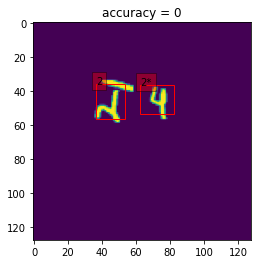

Training step: 300, running_loss: 117.4490,running_acc: 0.0000


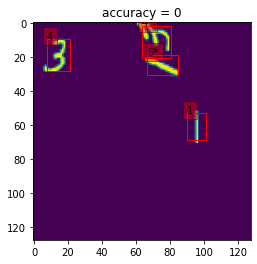

Training step: 300, running_loss: 58.0548,running_acc: 0.0000


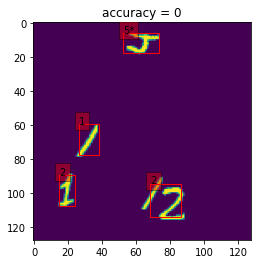

Training step: 600, running_loss: 55.8155,running_acc: 0.0000


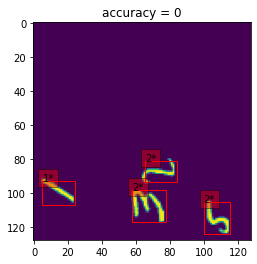

Training step: 900, running_loss: 52.7507,running_acc: 0.0000


  0%|          | 0/256 [00:00<?, ?it/s]

Test accuracy: 0.0508


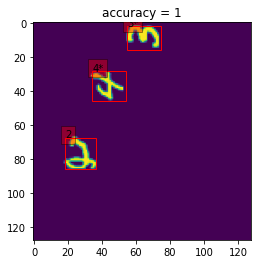

Training step: 1200, running_loss: 49.6507,running_acc: 0.2500


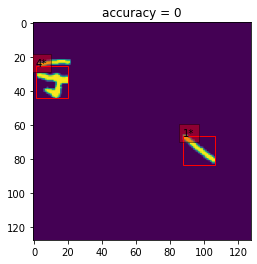

Training step: 1500, running_loss: 45.7708,running_acc: 0.2000


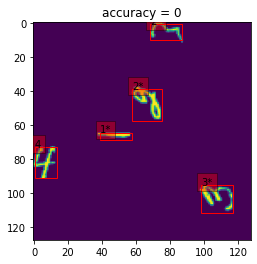

Training step: 1800, running_loss: 42.3223,running_acc: 0.1667


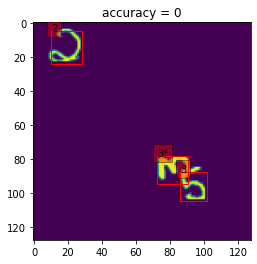

Training step: 2100, running_loss: 39.6772,running_acc: 0.1429


  0%|          | 0/256 [00:00<?, ?it/s]

Test accuracy: 0.5703


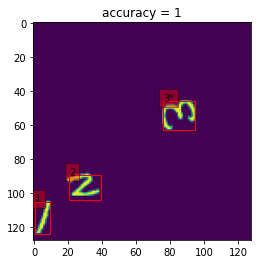

Training step: 2400, running_loss: 37.1393,running_acc: 0.2500


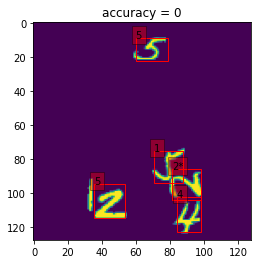

Training step: 2700, running_loss: 35.2536,running_acc: 0.2222


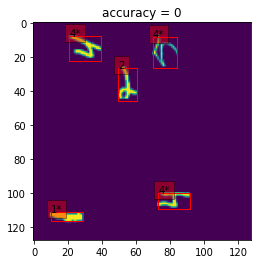

Training step: 3000, running_loss: 33.4543,running_acc: 0.2000


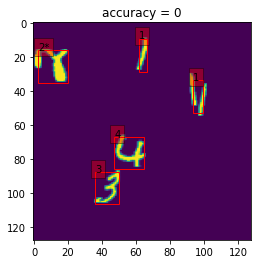

Training step: 3300, running_loss: 31.9491,running_acc: 0.1818


  0%|          | 0/256 [00:00<?, ?it/s]

Test accuracy: 0.5977


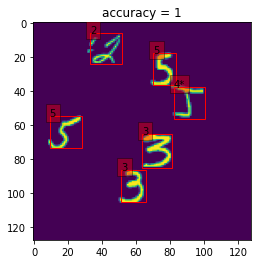

Training step: 3600, running_loss: 30.7381,running_acc: 0.2500


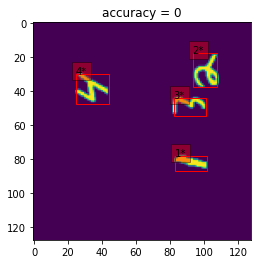

Training step: 3900, running_loss: 29.5542,running_acc: 0.2308


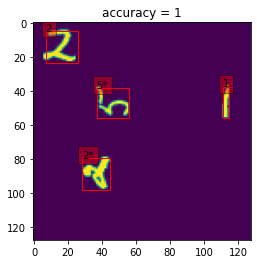

Training step: 4200, running_loss: 28.6345,running_acc: 0.2857


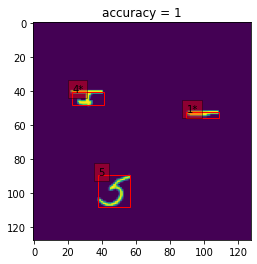

Training step: 4500, running_loss: 27.7599,running_acc: 0.3333


  0%|          | 0/256 [00:00<?, ?it/s]

Test accuracy: 0.7266


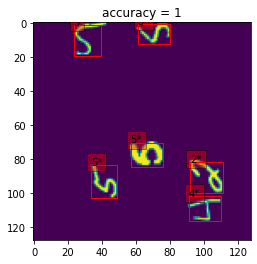

Training step: 4800, running_loss: 26.9329,running_acc: 0.3750


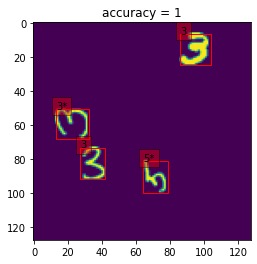

Training step: 5100, running_loss: 26.3015,running_acc: 0.4118


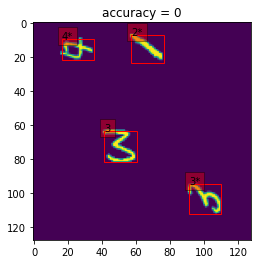

Training step: 5400, running_loss: 25.6296,running_acc: 0.3889


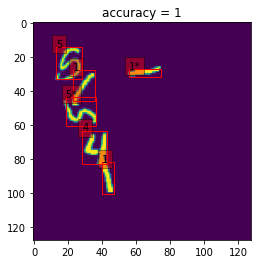

Training step: 5700, running_loss: 25.0146,running_acc: 0.4211


  0%|          | 0/256 [00:00<?, ?it/s]

Test accuracy: 0.7109


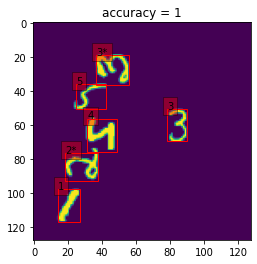

Training step: 6000, running_loss: 24.4250,running_acc: 0.4500


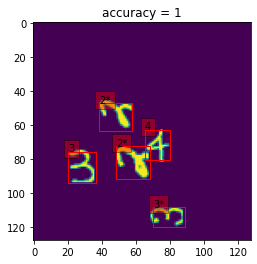

Training step: 6300, running_loss: 23.8486,running_acc: 0.4762


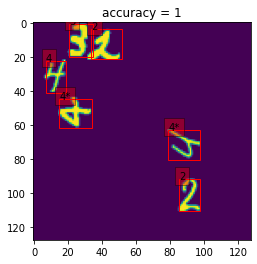

Training step: 6600, running_loss: 23.3672,running_acc: 0.5000


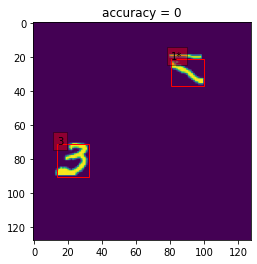

Training step: 6900, running_loss: 22.9463,running_acc: 0.4783


  0%|          | 0/256 [00:00<?, ?it/s]

Test accuracy: 0.7617


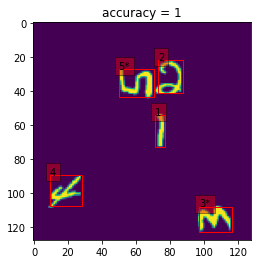

Training step: 7200, running_loss: 22.5685,running_acc: 0.5000


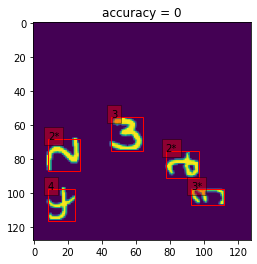

Training step: 7500, running_loss: 22.1886,running_acc: 0.4800


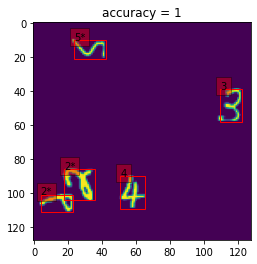

Training step: 7800, running_loss: 21.8445,running_acc: 0.5000


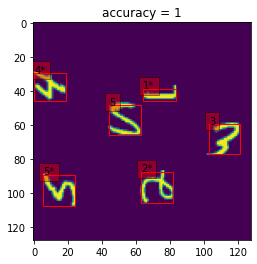

Training step: 8100, running_loss: 21.4809,running_acc: 0.5185


  0%|          | 0/256 [00:00<?, ?it/s]

Test accuracy: 0.7812


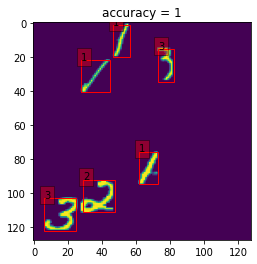

Training step: 8400, running_loss: 21.1464,running_acc: 0.5357


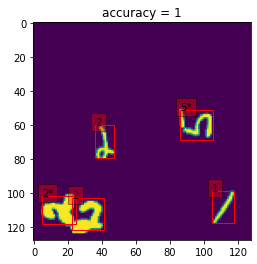

Training step: 8700, running_loss: 20.8155,running_acc: 0.5517


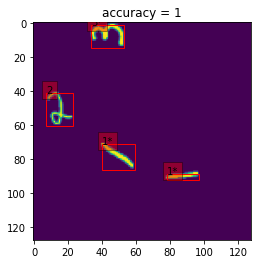

Training step: 9000, running_loss: 20.4635,running_acc: 0.5667


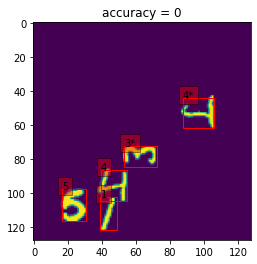

Training step: 9300, running_loss: 20.1749,running_acc: 0.5484


  0%|          | 0/256 [00:00<?, ?it/s]

Test accuracy: 0.6172


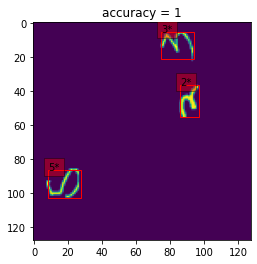

Training step: 9600, running_loss: 19.9190,running_acc: 0.5625


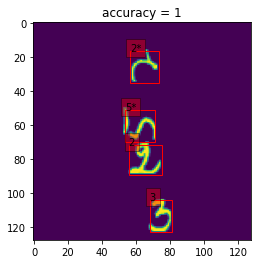

Training step: 9900, running_loss: 19.6595,running_acc: 0.5758


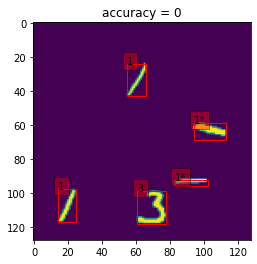

Training step: 10200, running_loss: 19.4359,running_acc: 0.5588


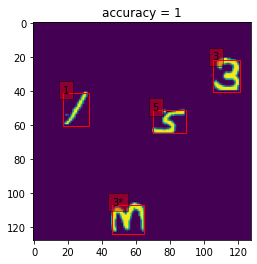

Training step: 10500, running_loss: 19.2074,running_acc: 0.5714


  0%|          | 0/256 [00:00<?, ?it/s]

Test accuracy: 0.7148


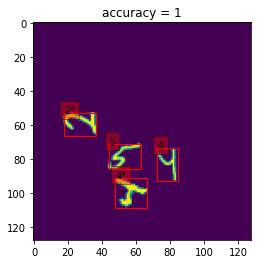

Training step: 10800, running_loss: 18.9822,running_acc: 0.5833


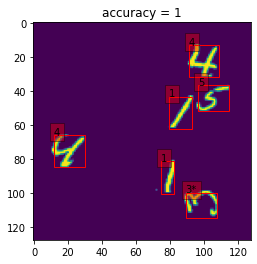

Training step: 11100, running_loss: 18.7749,running_acc: 0.5946


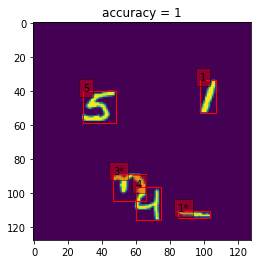

Training step: 11400, running_loss: 18.5813,running_acc: 0.6053


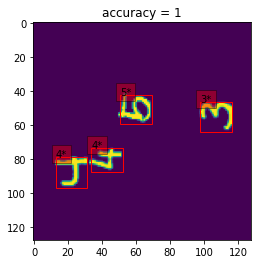

Training step: 11700, running_loss: 18.3820,running_acc: 0.6154


  0%|          | 0/256 [00:00<?, ?it/s]

Test accuracy: 0.7930


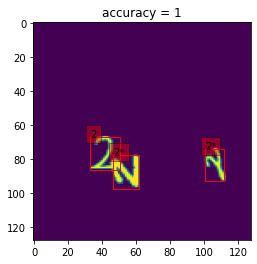

Training step: 12000, running_loss: 18.1825,running_acc: 0.6250


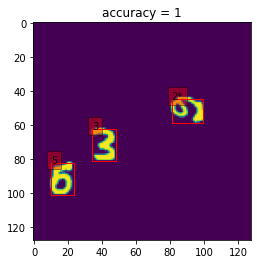

Training step: 12300, running_loss: 18.0117,running_acc: 0.6341


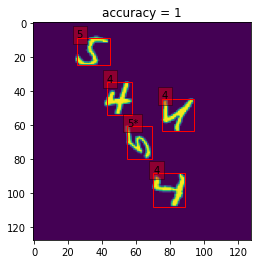

Training step: 12600, running_loss: 17.8452,running_acc: 0.6429


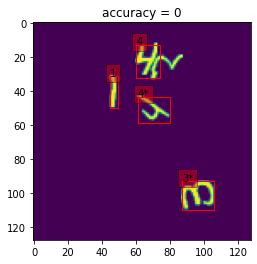

Training step: 12900, running_loss: 17.6896,running_acc: 0.6279


  0%|          | 0/256 [00:00<?, ?it/s]

Test accuracy: 0.8125


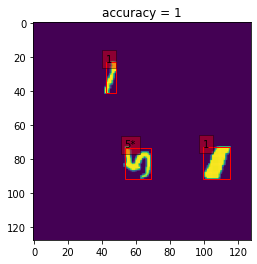

Training step: 13200, running_loss: 17.4991,running_acc: 0.6364


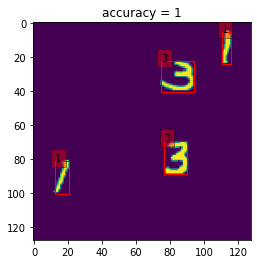

Training step: 13500, running_loss: 17.3629,running_acc: 0.6444


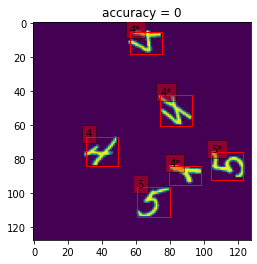

Training step: 13800, running_loss: 17.2090,running_acc: 0.6304


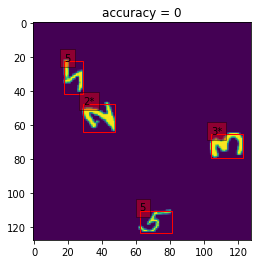

Training step: 14100, running_loss: 17.0702,running_acc: 0.6170


  0%|          | 0/256 [00:00<?, ?it/s]

Test accuracy: 0.8398


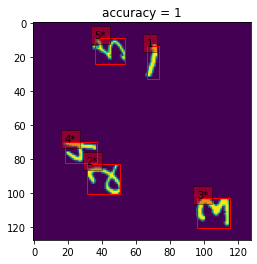

Training step: 14400, running_loss: 16.9167,running_acc: 0.6250


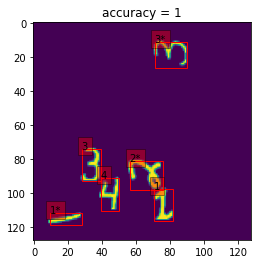

Training step: 14700, running_loss: 16.7896,running_acc: 0.6327


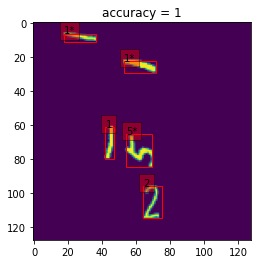

Training step: 15000, running_loss: 16.6623,running_acc: 0.6400


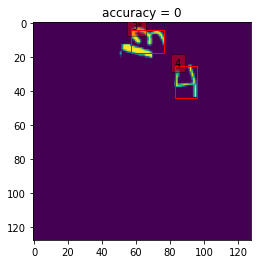

Training step: 15300, running_loss: 16.5316,running_acc: 0.6275


  0%|          | 0/256 [00:00<?, ?it/s]

Test accuracy: 0.8125


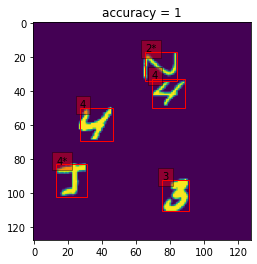

Training step: 15600, running_loss: 16.4036,running_acc: 0.6346


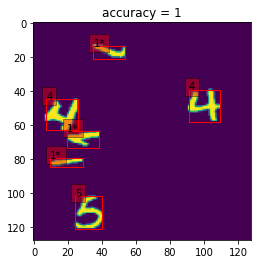

Training step: 15900, running_loss: 16.2769,running_acc: 0.6415


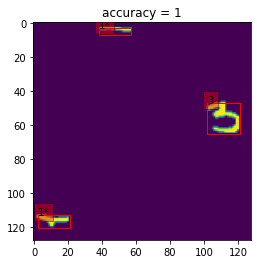

Training step: 16200, running_loss: 16.1548,running_acc: 0.6481


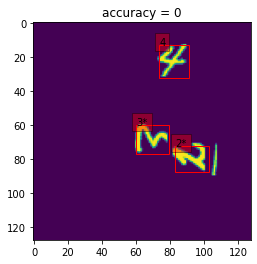

Training step: 16500, running_loss: 16.0514,running_acc: 0.6364


  0%|          | 0/256 [00:00<?, ?it/s]

Test accuracy: 0.8086


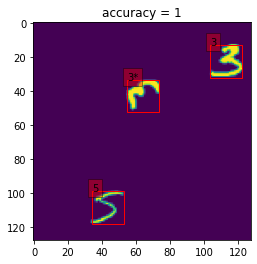

Training step: 16800, running_loss: 15.9607,running_acc: 0.6429


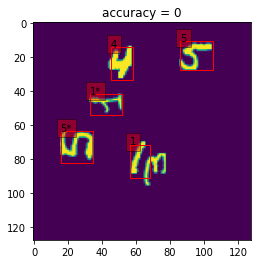

Training step: 17100, running_loss: 15.8537,running_acc: 0.6316


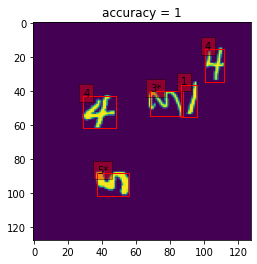

Training step: 17400, running_loss: 15.7495,running_acc: 0.6379


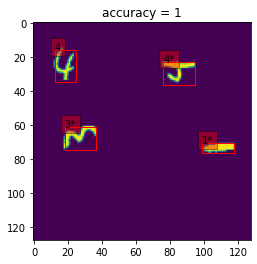

Training step: 17700, running_loss: 15.6494,running_acc: 0.6441


  0%|          | 0/256 [00:00<?, ?it/s]

Test accuracy: 0.8086


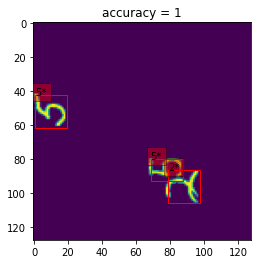

Training step: 18000, running_loss: 15.5355,running_acc: 0.6500


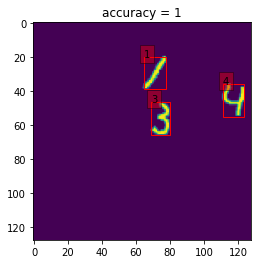

Training step: 18300, running_loss: 15.4368,running_acc: 0.6557


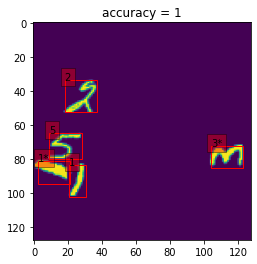

Training step: 18600, running_loss: 15.3321,running_acc: 0.6613


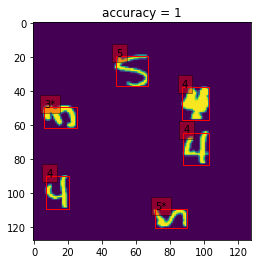

Training step: 18900, running_loss: 15.2430,running_acc: 0.6667


  0%|          | 0/256 [00:00<?, ?it/s]

Test accuracy: 0.7812


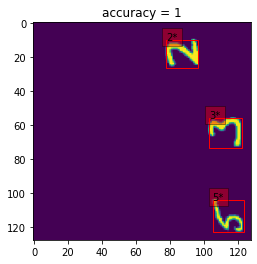

Training step: 19200, running_loss: 15.1515,running_acc: 0.6719


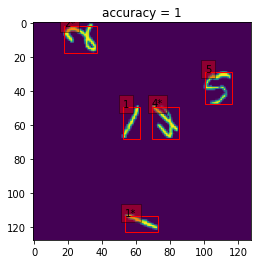

Training step: 19500, running_loss: 15.0620,running_acc: 0.6769


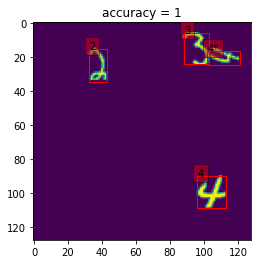

Training step: 19800, running_loss: 14.9620,running_acc: 0.6818


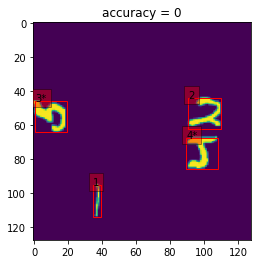

Training step: 20100, running_loss: 14.8673,running_acc: 0.6716


  0%|          | 0/256 [00:00<?, ?it/s]

Test accuracy: 0.6016


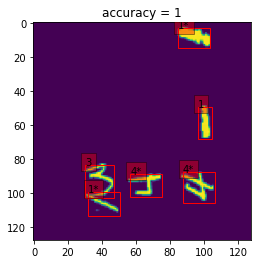

Training step: 20400, running_loss: 14.7861,running_acc: 0.6765


In [20]:
for step in tqdm(range(steps)):
    canvas = get_random_canvas()
    model_output = ddm(canvas)
    model_target = td.get_targets(canvas, model_output.anchors)
    loss = criterion.compute_loss(model_output, model_target)
    if not loss:
        print('There are no matched anchors.')
        continue
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    
    if (step + 1) % val_step == 0:
        predicted_boxes = td.get_predictions(model_output)
        train_acc = acc_metric.compute_metric(predicted_boxes, canvas)
        title = f'accuracy = {train_acc}'
        running_acc += train_acc
        new_canvas = MnistCanvas(canvas.image, predicted_boxes)
        new_canvas.plot(title=title)
        running_acc_denominator = (step + 1 - back) // val_step
        print(f'Training step: {step + 1 - back}, running_loss: {running_loss / (step + 1 - back):.4f},'\
                                        f'running_acc: {running_acc / running_acc_denominator:.4f}')
        if (step + 1) % (val_step * 4) == 0:
            test_acc = 0
            ddm.eval()
            for canvas in tqdm(TEST_CANVAS):
                with torch.no_grad():
                    test_model_output = ddm(canvas)
                test_predicted_boxes = td.get_predictions(test_model_output)
                test_acc += acc_metric.compute_metric(test_predicted_boxes, canvas)
            
            test_acc = test_acc / len(TEST_CANVAS)
            test_acc_array.append(test_acc)
            print(f'Test accuracy: {test_acc:.4f}')
            ddm.train()
            
        if (step + 1) == val_step:
            running_loss = 0
            running_acc = 0
            back = val_step


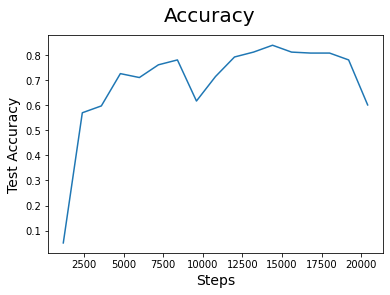

In [21]:
fig = plt.figure()
plt.plot(np.arange(17) * 1200 + 1200, test_acc_array)
fig.suptitle('Accuracy', fontsize=20)
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=14)
plt.show()

## Plot example results of matched and mismatched predictions (2pt).

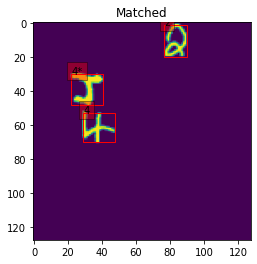

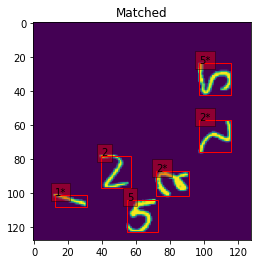

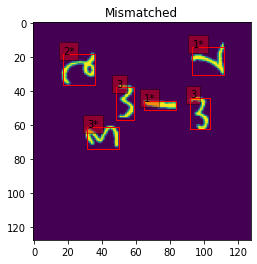

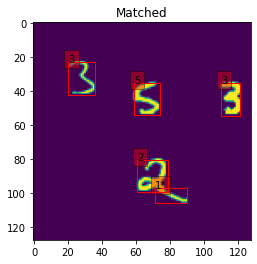

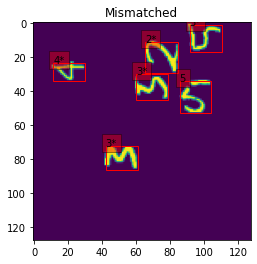

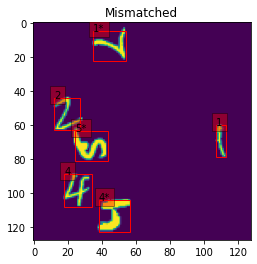

In [30]:
mismatched_pred = 0
matched_pred = 0

ddm.eval()
while matched_pred < 3 or mismatched_pred < 3:
    canvas = TEST_CANVAS[np.random.randint(0, 100)]
    with torch.no_grad():
        test_model_output = ddm(canvas)
    test_predicted_boxes = td.get_predictions(test_model_output)
    test_acc = acc_metric.compute_metric(test_predicted_boxes, canvas)
    if test_acc and matched_pred < 3:
        new_canvas = MnistCanvas(canvas.image, test_predicted_boxes)
        new_canvas.plot(title='Matched')
        matched_pred += 1
    elif not test_acc and mismatched_pred < 3:
        new_canvas = MnistCanvas(canvas.image, test_predicted_boxes)
        new_canvas.plot(title='Mismatched')
        mismatched_pred += 1

# Report

The model consists of three identical heads, two of which have the sigmoid activation function applied during prediction and while calculating the loss function.
The training was set at 20,700 steps, during which single canvas were randomly drawn, for which the loss function was calculated. The accuracy was calculated every 300 steps on the training set, and every 1200 on the test set. The variables holding the metric results were reset after the first 300 steps. The training was carried out using the Adam optimizer with the learning rate parameter set to 0.001. Each of the heads consisted of 3 convolutional layers with 256 features and preceded by the ReLU activation function, except for the last one, the output of which and the size of the output were selected according to the recommendations from the content of the task. A total of 9 sizes of anchors were selected, after noticing that one of the dimensions must always be 19. So, the dimensions selected are those whose sum is congruent with 2 modulo 4. This reduced the total number of initial anchors to almost 1/4, with no loss to the necessary completion of the quest objective. By far the biggest problem with class detection and prediction is overlapping numbers. A smaller but common challenge is also 2 and 3 written so narrow that they look like 1. The most common undetected number is 1, especially when its iou with another number is nonzero.